# Heuristic

This heuristic starts with solving the TSP on the circles centers.
Then the optimal hitting points for the corresponding order are computed.
These points are repeatedly used as new centers for the TSP optimization.

In [10]:
import typing

class Circle:
    """
    Instance representation
    """
    def __init__(self, x: float, y: float, radius: float):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, r={self.radius})"

    def __eq__(self, other):
        return self.x == other.x and  self.y == other.y and self.radius == other.radius

    def __hash__(self):
        return hash((self.x, self.y ,self.radius))

# simple plotting  helper
import matplotlib.pyplot as plt
def plot_circle(ax: plt.Axes, circle: Circle, **kwargs):
    patch = plt.Circle((circle.x, circle.y), radius=circle.radius, **kwargs)
    ax.add_patch(patch)

In [11]:
import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB




def compute_hitting_points(circle_sequence: typing.List[Circle], path: bool=False) -> typing.Dict[Circle, typing.Tuple[float ,float]]:
    """
    This function efficiently computes the optimal CE-Tour for a given sequence(!) of circles.
    If the order of circles is given, the problem becomes an easy to solve SOC-Program.
    The tour may implicitly cross circles earlier.

    Learn more about SOC: https://www.gurobi.com/events/gurobi-qcp-and-socp-optimizer-overview/
    :param circle_sequence: Sequence of circles (the exact order they are visited)
    :param path: Compute a path instead of a tour.
    :return: Sequence of coordinates of the tour. The coordinates may be slightly off (but not critical).
    """
    model = gp.Model()

    # tour points
    x = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    y = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # length of segments
    f = model.addVars(circle_sequence, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    model.setObjective(gp.quicksum(f.values()), sense=GRB.MINIMIZE)

    # x and y-length of segments (difference of segment points)
    w = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    u = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # difference of tour points to circle center
    s = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    t = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # SOC
    for c in circle_sequence:
        model.addQConstr(f[c]*f[c] >= w[c]*w[c] + u[c]*u[c])
        # tour points are within circle radius
        model.addQConstr(s[c]*s[c] + t[c]*t[c] <= c.radius*c.radius)

        # enforce s,t represent difference to circle center
        model.addConstr(s[c] == c.x - x[c])
        model.addConstr(t[c] == c.y - y[c])

    for i, c in enumerate(circle_sequence):
        if path and i==0:
            # for paths, the distance between the endpoints
            # is free
            model.addConstr(w[c]==0)
            model.addConstr(u[c]==0)
        else:
            # enforce w,u represent segment lengths (x and y axes)
            prev_c = circle_sequence[(i-1)%len(circle_sequence)]
            model.addConstr(w[c] == x[prev_c] - x[c])
            model.addConstr(u[c] == y[prev_c] - y[c])

    model.optimize()
    return {c: (x[c].X, y[c].X) for c in circle_sequence}

In [30]:
from concorde.tsp import TSPSolver
import typing
def compute_tour(points: typing.List[typing.Tuple[float, float]]) -> typing.List[int]:
    solver = TSPSolver.from_data([x for x,y in points], [y for x,y in points], norm="EUC_2D")
    solution = solver.solve(verbose=False)
    return [int(i) for i in solution.tour]

def find_good_tour(circles: typing.List[Circle], iterations=10) -> typing.List[int]:
    tour = [i for i in range(len(circles))]
    hitting_points = {c: (c.x, c.y) for c in circles}
    for _ in range(iterations):
        tour = compute_tour([hitting_points[c] for c in circles])
        hitting_points = compute_hitting_points([circles[i] for i in tour])
    return tour


In [28]:
circles = [
    Circle(2*x, 2*y, 1) for x in range(15) for y in range(15)
]

Problem Name: 15b468a126f7480db6d69957f53da246
Problem Type: TSP
Number of Nodes: 225
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 520
   0 Steps   Best: 453   0.00 seconds
   4 Steps   Best: 451   0.00 seconds
 112 Total Steps.
Best cycle length: 451
Lin-Kernighan Running Time: 0.03
LK Initial Run: 451.0
LK Run 0: 451.0
LK Run from best tour: 451.0
Time to find compression tour: 0.12 (seconds)
Set initial upperbound to 451 (from tour)
  LP Value  1: 451.000000  (0.06 seconds)
New lower bound: 451.000000
Exact lower bound: 451.000000
DIFF: 0.000000
Established Bound: 451
Optimal tour: 451
Total Time to solve TSP: 0.23
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 900 rows, 1575 columns and 2250 nonzeros
Model finger

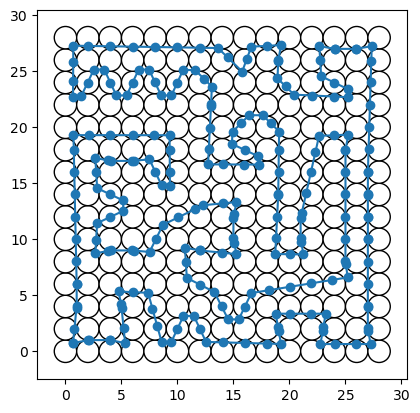

In [31]:
fig = plt.Figure(figsize=(15,15))
ax = plt.gca()
tour = find_good_tour(circles, 20)
hitting_points = compute_hitting_points([circles[i] for i in tour])
tour = [hitting_points[circles[i]] for i in tour]
for c in circles:
    plot_circle(ax, c, facecolor="white", zorder=1, ec="black")
plt.plot([p[0] for p in tour]+[tour[0][0]], [p[1] for p in tour]+[tour[0][1]], 'o-')
ax.set_aspect('equal', 'box')
plt.show()